Reducir la dimensionalidad causa perdida de información, aumenta la rapidez del entrenamiento pero baja el rendimiento del sistema. También hace más complicadas las `pipeline` y dificiles de mantener. Primero es mejor entrenar el sistema con los datos originales antes de considerar la reducción de dimensionalidad, en algunos casos la reducción filtra algun ruido y detalles innecesarios redultando en mejor rendimiento, pero no en general.

Reducir la dimensionalidad ayuda a la visualización de los datos, reducir el numero de dimensiones a dos o tres ayuda a visualizarlos mejor detectando patrones o grupos.

## La maldición de la dimensionalidad

Entre más dimensiones tiene los datos una nueva observación está más lejos de los datos de entrenamiento y las predicciones serán menos confiables que en menos dimensiones, ya que estarán hechas en extrapolaciones más largas. Entre más dimensiones más peligro se sobreajustar. 

## Los principales métodos para reducir la dimensionalidad

### Proyección

Las observaciones muchas veces son constantes mientras otras son altamente correlacionadas, entonces todas las observaciones caen cerca a un subespacio de menor dimensión, entonces se proyectan en este subespacio de menor dimensión.

### Manifold

En muchos casos el subespacio no es un plano en el cual se pueda proyectar, en estos casos si se proyecta en un plano se puede aplastar la información, en este caso se querría mejor desenrollar los datos, por ejemplo:

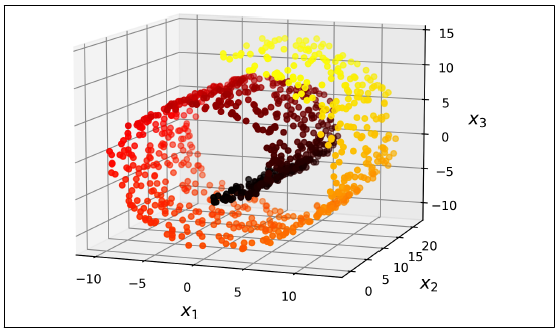

A la izquierda se proyecta en un plano y a la derecha se desenrolla

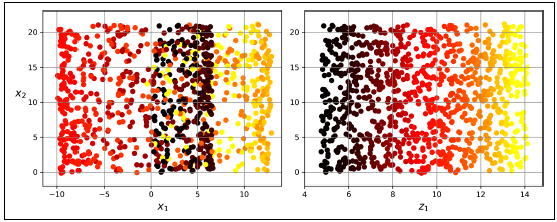

Este es un ejemplo de un manifold en dos dimensiones. Un manifold en 2D es una figura en 2D que se puede doblar y girar en un espacio dimensional más grande.

Muchos algoritmos de reducción de dimensionalidad trabajan modelando el manifold, esto se llama `aprendizaje manifold`, depende en el `supuesto manifold` llamado `hipotesis manifold`, la cual dice que la mayoria de datos de dimensiones altas caen cerca a un manifold de muchas menos dimensiones, este supuesto se observa empiricamente.

Ahora se revisan los algoritmos más populares para reducción de dimensionalidad.

## PCA

Identifica un hiperplano que cae más cerca a los datos y proyecta los datos en el.

### Preservando la varianza

El primer paso es escoger el hiperplano correcto, esto se hace con el plano que conserve la máxima cantidad de varianza, por ejemplo:

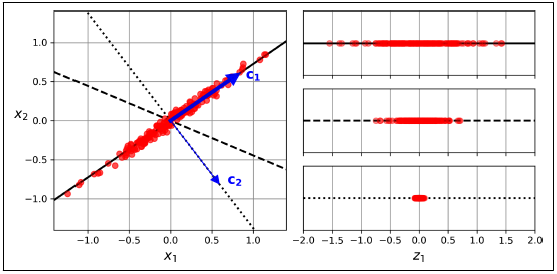

La opción de arriba a la derecha contiene la mayor cantidad de varianza, la de abajo a la derecha contiene la menor cantidad de varianza. Otra forma de justificar la opción es el eje que minimice la distacia media cuadrada entre los datos originales y su proyección en el eje, esa es la idea detrás de `PCA`.

### Componentes principales

`PCA` identifica el eje que cuente con las mayor cantidad de varianza en el conjunto de entrenamiento, luego encuentra un segundo eje, ortogonal al primero, que cuente con la mayor cantidad de las varianza restante, `PCA` también encuentra más ejes ortogonal al eje previo, tantos ejes como dimensiones en los datos.

El eje $i$ es llamado el $i$-esimo componente principal de los datos. El primer componente principal es el eje en el cual el vector $c_1$ cae, el segundo componente principal es el eje en el cual el vector $c_2$ cae. Los primeros dos ejes están en el plano de proyección, si hay tercer componente es ortogonal a ese plano.

Para encontrar los componentes principales en el conjunto de entrenamiento usamos una factorización de matrices llamada `singular value decomposition (SVD)` que descompone la matriz de entrenamiento $X$ en una multiplicación de tres matrices $U \Sigma V^T$, donde $V$ contiene los vectores unidad que definen los componentes principales.

$$
V = \begin{bmatrix} \vdots & \vdots & & \vdots \\
c_1 & c_2 & \cdots & c_n \\
\vdots & \vdots & & \vdots \end{bmatrix}
$$

Aquí un ejemplo usando numpy:

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Para hacer `PCA` asume que los datos están centrados, scikit learn hace esto automaticamente.

### Proyectar a menos d dimensiones

Una vez que se tengan los componentes principales se pueden reducir a los datos a d dimensiones proyectando al hiperplano definido por los primeros d componentes principales, seleccionando este hiperplano nos aseguramos que se tenga la mayor varianza posible.

Para proyectar los datos de entrenamiento en el hiperplano y obtener datos reducidos $X_{d-proj}$ de dimensionalidad $d$, se computa la multiplicación de matriz del conjunto de entrenamiento $X$ por la matrix $W_d$ definida como la matriz que contienen las primeras $d$ columnas de $V$, 

$X_{d-proj} = XW_d$

Ahora se encuentra en código,

In [2]:
W2 = Vt[:2].T
X2D = X_centered @ W2

### Usando Scikit learn

Scikit usa la clase SVD para implementar PCA, por ejemplo:

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

### Radio de varianza explicada

Otra información importante es el `radio de varianza explicada` de cada componente principal, disponible en la variable `explained_variance_ratio_`. Indica la proporción de la varianza que cae en cada componente principal.

In [4]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

76% de la varianza está en el primer componente principal y 15% dentro del segundo. El tercer componente principal quedaría con 6%, lo que indicaría que el tercer componente principal tiene poca información.

### Escoger el número correcto de dimensiones

Se pueden escoger el numero de dimensiones que sumen una proporción de la varianza que queramos, por ejemplo, 95% (Para visualización se debería reducir a 2 o 3 dimensiones).

Ahora se hace PCA en el conjunto MNIST sin reducir la dimensionalidad, computa el minimo numero de dimensiones requeridas para preservar 95% de la varianza del entrenamiento.

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train) # no se reduce, solo se ajusta
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

Se necesitarían 154 componentes principales, se puede establecer `n_components = d` en PCA, pero hay una mejor opción, en cambio se puede especificar el radio de varianza que se quiere preservar con `n_components = 0.95`

In [6]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

Ahora podemos ver esto de forma gráfica,

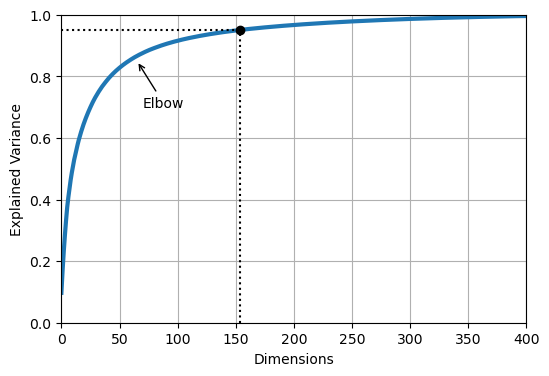

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

En esta gráfica se observa un *codo* donde después de este número de dimensiones no se aumenta la varianza explicada mucho. Ahora se presenta un ejemplo de como incoporar esta reducción de dimensiones en una `pipeline` y el numero de dimensiones en una busqueda de hiperparámetros para ajustarlo,

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state = 42),
                   RandomForestClassifier(random_state = 42))

param_distrib = {
    'pca__n_components': np.arange(10, 80),
    'randomforestclassifier__n_estimators': np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter = 10, cv = 3,
                               random_state = 42)

rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       

In [9]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


Se redujo un conjunto de 784 dimensiones a sólo 23 dimensiones.

### PCA para compresión

Luego del PCA el conjunto ocupa menos espacio, por ejemplo, luego de aplicar PCA al conjunto MNIST preservando 95% de varianza nos quedamos con 154 variables en vez de las 784 variables. Tenemos 20% menos de datos y solo perdimos 5% de varianza.

También se puede aplicar la transformación inversa de la proyección PCA. No va a dar los datos originales ya que se pierde un poco de información pero va a ser cercano, esto se conoce como el `error de reconstrucción`.

In [10]:
X_recovered = pca.inverse_transform(X_reduced)

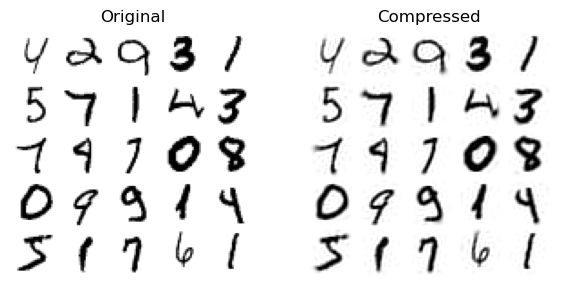

In [11]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

$$
X_{recovered} = X_{d-proj}W_d^T
$$

### PCA aleatorio

Si se establece `svd_solver = 'randomized'`, scikit usa el algoritmo estocastico llamado `PCA aleatorizado` que encuentra la aproximación de los $d$ componentes principales bastantes rápido,

In [12]:
rnd_pca = PCA(n_components = 154, svd_solver = 'randomized', random_state = 42)
X_reduced = rnd_pca.fit_transform(X_train)

Por defecto `svd_solver` está en `auto`, scikit usa el `PCA aleatorizado` si $max(m, n) > 500$ y `n_components` es un entero menor al 80% del $min(m, n)$ de otra forma usa el SVD completo, para hacer el SVD completo se puede establecer `svd_solver = 'full'`.

### PCA incremental

Un problema con las implementaciones del PCA es que requieren que todo el conjunto de entrenamiento esté en memoria para correr, PCA incremental divide el conjunto en 100 mini lotes y los da a scikit `IncrementalPCA` para reducir la dimensión a 154 dimensiones. Aquí solo se debe llamar `partial_fit()` 

In [13]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

también se puede hacer con la case `memmap` de Numpy, permite manipular un arreglo grande guardado en un archivo binario en disco como si estuviera en la memoria, la clase carga el archivo en memoria cuando lo necesita,

En caso de tener muchas dimensiones, el entrenamiento puede ser muy lento, en este caso podemos usar proyecciones aleatorias.

### Proyecciones aleatorias

Se usa una proyección lineal aleatoria. Una proyección aleatoria tiene alta posibilidad de preservar las distancias bien, dos observaciones similares seguirán siendo similares luego de la proyección y dos observaciones diferentes seguirán siendo diferentes.

Entre más dimensiones se quiten, más información se pierde y las distancias se distorcionan más. *Johnson y Lindenstrauss* encontraron una ecuación para encontrar el óptimo numero de ecuaciones, asegurandose con alta probabilidad que las distancias no cambien más que cierta tolerancia. 

Por ejemplo, si se tienen $m = 5000$ observaciones con $n = 20000$ variables y no se quiere que la distancia al cuadrado de ningún par de observaciones cambie mas de $\epsilon = 10\%$, tienes que reducir la dimensión a $d$ con $d \geq 4 \log(m) / (1/2 \epsilon^2 - 1/3 \epsilon^3)$ lo cual da 7300 dimensiones, esta función se implementa así,

In [14]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, e = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps = e)
d

7300

Ahora generamos una matriz aleatoria P de tamaño [d, n], donde cada elemento es muestreado aleatoriamente de una distribución Gaussiana con media 0 y varianza $1/d$ y usarla para proyectar unos datos de n dimensiones a d

In [15]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n)
X_reduced = X @ P.T

In [16]:
# Se puede hacer en scikit 
# Usa automaticamente johnson_lindenstrauss_min_dim para determinar la dimensión
# guarda la matriz aleatoria en components_
# cuando se llama transform usa la matriz para hacer la proyección

from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps = e, random_state = 42)
X_reduced = gaussian_rnd_proj.fit_transform(X) # mismo resultado

Scikit también tiene otra clase llamada `SparseRandomProjection`. Determina la dimensionalidad de la misma forma, genera la matriz aleatoria del mismo tamaño y hace la proyección. La principal diferencia es que la matriz aleatoria es *sparse*, usa mucha menos memoria y es más rápida. Si el input es sparse la transformación lo mantiene sparse (a menos que establezcas `dense_output = True`, tiene la misma propiedad de mantener la distancia. Usualmente es preferible usar esta, sobretodo para datos muy grandes.

El radio de elementos no cero en una matriz aleatoria sparse es llamado `densidad`. Por defecto es $1/\sqrt{n}$. Cada celda de la matriz tiene una probabilidad $r$ de ser no cero, y cada valor no cero es igual a $-v$ o $+v$, donde $v = 1/\sqrt{dr}$.

Si se quiere hacer la inversa primero hay que computar la pseudo inversa y multiplicar los datos reducidos por la transpuesta de la pseudo inversa:

In [17]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T # toma vario tiempo para calcular

## LLE 

`Local linear embedding` es una técnica de *reducción de dimensión no lineal*. Es aprendizaje `manifold` que no depende de proyecciones. LLE funciona midiendo como cada observación se relaciona linealmente a sus vecinos cercanos y busca una representación de baja dimensión representando el conjunto de entrenamiento donde estas relaciones se preserven bien. Este metodo es bueno para desenrollar manifolds, especialmente cuando hay poco ruido, por ejemplo:


In [18]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10, random_state = 42)
X_unrolled = lle.fit_transform(X_swiss)

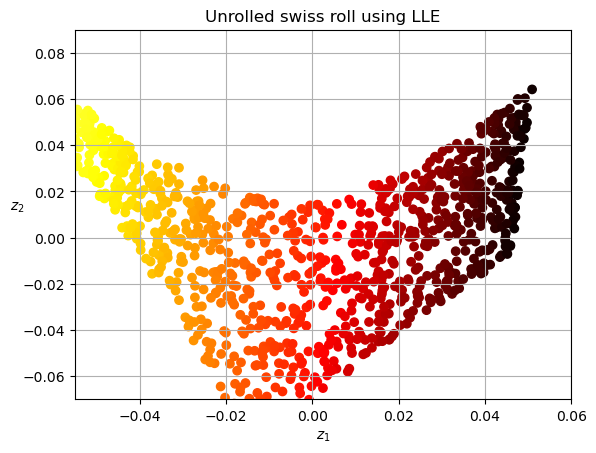

In [19]:
from matplotlib.colors import ListedColormap
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()

Vemos que hace un buen trabajo desenrollando los datos y las distancias locales se preservan. Sin embargo las distancias no se preservan tan bien a gran escala, la figura desenrollada debería ser un rectangulo, sin embargo el LLE hace un buen trabajo modelando el manifold.

Así funciona el LLE: para cada observación $x^i$ el algoritmo identifica sus k vecinos mas cercanos y trata de construir $x^i$ como una función lineal de los vecinos. Trata de encontrar los pesos $w_{i,j}$ tales que la distancia entre $x^i$ y $\sum w_{i,j}x^j$ sea tan pequeña como sea posible, con $w_{i,j} = 0$ si $x^j$ no es parte de los vecinos.

Luego el primer paso de LLE es una optimización restringida dado por la ecuación:

$\begin{aligned} & \widehat{\mathbf{W}}=\underset{\mathbf{W}}{\operatorname{argmin}} \sum_{i=1}^m\left(\mathbf{x}^{(i)}-\sum_{j=1}^m w_{i, j} \mathbf{x}^{(j)}\right)^2 \\ & \text { subject to } \begin{cases}w_{i, j}=0 & \text { if } \mathbf{x}^{(j)} \text { is not one of the } k \text { n.n. of } \mathbf{x}^{(i)} \\ \sum_{j=1}^m w_{i, j}=1 & \text { for } i=1,2, \cdots, m\end{cases} \end{aligned}$

La matriz $\hat{W}$ codifica la relacion lineal local entre las observaciones de entrenamiento. El segundo paso es mapear estas observaciones a un espacio d dimensional preservando estas relaciones locales lo más posible.

Si $Z^i$ esd la imagen de $x^i$ en este espacio d dimensional, entonces queremos que la distancia al cuadrado entre $Z^i$ y $\sum\hat{w}x^j$ sea tan pequeña como sea posible, esto lleva a un problema de optimización sin restricción dada por la siguiente ecuación:

$\widehat{\mathbf{Z}}=\underset{\mathbf{Z}}{\operatorname{argmin}} \sum_{i=1}^m\left(\mathbf{z}^{(i)}-\sum_{j=1}^m \widehat{w}_{i, j} \mathbf{z}^{(j)}\right)^2$

En vez de encontrar los pesos óptimos hacemos el reverso: dejamos los pesos fijos y encontramos la posición óptima de las imagenes de las observaciones en el espacio dimensional pequeño.

LLE es más complejo pero también construye mejores representaciones de baja dimensión, especialmente si los datos son no lineales.

## Otras tecnicas de reducción de dimensión

- *sklearn.manifold.MDS*

        *Multidimensional scaling*: reduce la dimensionalidad tratando de preservar las distancias entre observaciones. La proyección aleatoria lo hace para datos de alta dimensión pero no funciona bien para datos de baja dimensión.
    
- *sklearn.manifold.Isomap*

        *Isomap*: Crea una grafica conectando cada instancia a sus vecinos más cercanos, reduce la dimensionalidad tratando de preservar las *distancias geodesicas* entre observaciones. La distancia geodesica en un grafico es el numero de nodos en el camino más corto entre nodos
        
- *sklearn.manifold.TSNE*

        *T distributed stochastic neighbor embedding (t-SNE)*: reduce la dimensionalidad mientras intenta mantener observaciones similares cerca y observaciones no similares lejos. Se usa más que todo para visualización, en particular para visualizar clusters de observaciones en espacios de alta dimensión.
        
- *sklearn.discriminant_analysis.LinearDiscriminantAnalysis*
        
        *Analisis discriminante lineal*: Es un algoritmo de clasificación que durante el entrenamiento aprende los ejes más discriminantes entre clases. Estos ejes pueden ser usados para definir un hiperparámetro para proyectar los datos. La proyección mantiene las clases lo más lejos posible, LDA es una buena tecnica de reducción de dimensionalidad antes de correr un algoritmo de clasificación (LDA en ocasiones puede ser suficiente).

In [20]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

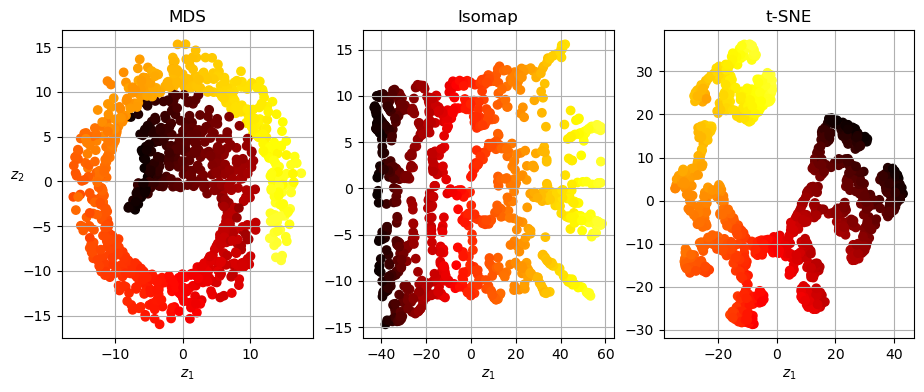

In [21]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()

## Kernel PCA

También existen los PCA con kernels

In [22]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

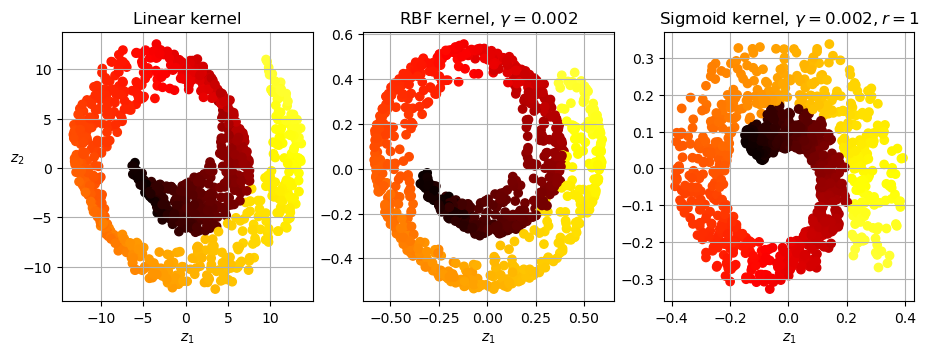

In [23]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()

## Ejercicios 


1. What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

    La motivación principal para reducir la dimensionalidad de un conjunto de datos es la velocidad con la cual se pueden entrenar los modelos, otra razón es la de visualizar mejor las relaciones o ahorrar espacio. Los problemas es que al reducir la dimensionalidad se pierde información, lo que puede llevar a tener modelos con menor rendimiento; puede ser computacionalmente dificil, añade complejidad a las pipelines y los datos pierden interpretabilidad.

2. What is the curse of dimensionality?

    La maldición de la dimensionalidad hace referencia a muchos problemas que no existen en pocas dimensiones salen en hartas dimensiones. Un ejemplo común es que muestras aleatorias de vectores de alta dimensión están lejos el uno del otro aumentando el riesgo de sobreajuste.
    
3. Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

    Es posible revertir la operación pero no a los datos originales en algunos algoritmos como PCA, otros algoritmos como t-SNE no es posible reconstruirlo.
    
4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

    PCA puede reducir la dimensión de la mayoría de datos aun si son no lineales. Si no hay dimensiones inutiles reducir la dimensionalidad con PCA hace que se pierda mucha información.
    
5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?

    Depende de los datos. Suponga que se tienen datos alineados casi perfectos, en este caso el PCA puede reducir solo una dimensión mientras preserva el 95% de la varianza. Ahora si los datos son todos aleatorios, en este caso casi 950 dimensiones son necesarias para preservar el 95% de la varianza.
    
6. In what cases would you use regular PCA, incremental PCA, randomized PCA, or random projection?

    El PCA regular es por defecto pero solo funciona si los datos caben en memoria, Incremental PCA funciona para datos que no caben en la memoria pero es más lento que el PCA, PCA incremental también es útil para tareas en linea. PCA aleatorio es útil cuando los datos caben en memoria y se desea reducir considerablemente la dimensión, es mucho más rápido que el PCA. Proyección aleatoria es bueno para datos de muy alta dimensionalidad.
    
7. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

   Un algoritmo de reducción de dimensionalidad rinde bien si elimina muchas dimensiones sin perder mucha información. Una forma de medir esto es aplicar la transformación al revés y medir el error de construcción. Para algoritmos que no tienen esta transformación, si se usa la reducción como un paso para un modelo, si la dimensión de reducción no pierde mucha información entonces el modelo debería tener un rendimiento igual a usar los datos originales.
   
8. Does it make any sense to chain two different dimensionality reduction algorithms?

    Si tiene sentido, un ejemplo es usar PCA o proyección aleatoria para quitar un número grande de dimensiones inutiles, luego aplicar un algoritmo más lento como LLE. Esto debería tener el mismo rendimiento que sólo LLE pero en mucho menos tiempo.

9. Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [24]:
mnist = fetch_openml('mnist_784', as_frame = False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

    Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
%time rf_clf.fit(X_train, y_train)

Wall time: 40.3 s


RandomForestClassifier()

In [26]:
from sklearn.metrics import accuracy_score

y_pred = rf_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9713

    Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [27]:
pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)

     Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?

In [28]:
%time rf_clf.fit(X_train_reduced, y_train)

Wall time: 1min 23s


RandomForestClassifier()

Se demoró casi el triple, PCA no siempre ayuda al rendimiento, depende de los datos y del algoritmo.


Next evaluate the classifier on the test set: how does it compare to the previous classifier?

In [29]:
X_test_reduced = pca.transform(X_test)

y_pred = rf_clf.predict(X_test_reduced)
accuracy_score(y_pred, y_test)

0.949

En este caso se empeoró el rendimiento y se aumentó el tiempo de entrenamiento.

    Try again with an SGDClassifier. How much does PCA help now?

In [30]:
from sklearn.linear_model import SGDClassifier

SGD_clf = SGDClassifier(random_state = 42)
%time SGD_clf.fit(X_train, y_train)

Wall time: 2min 9s


SGDClassifier(random_state=42)

In [31]:
y_pred = SGD_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.874

In [32]:
%time SGD_clf.fit(X_train_reduced, y_train)

Wall time: 30.3 s


SGDClassifier(random_state=42)

Para este algoritmo el tiempo si disminuyó mucho, vamos a ver el rendimiento.

In [33]:
y_pred = SGD_clf.predict(X_test_reduced)
accuracy_score(y_pred, y_test)

0.8959

Aquí la reducción de dimensionalidad ayuda mucho tanto en el tiempo de ejecución como en el rendimiento.

10. Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.

In [34]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

In [35]:
# ahora se usa t-SNE para reducir la dimensionalidad

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, init = 'random', learning_rate = 'auto',
           random_state = 42)
%time X_reduced = tsne.fit_transform(X_sample)

Wall time: 16.1 s


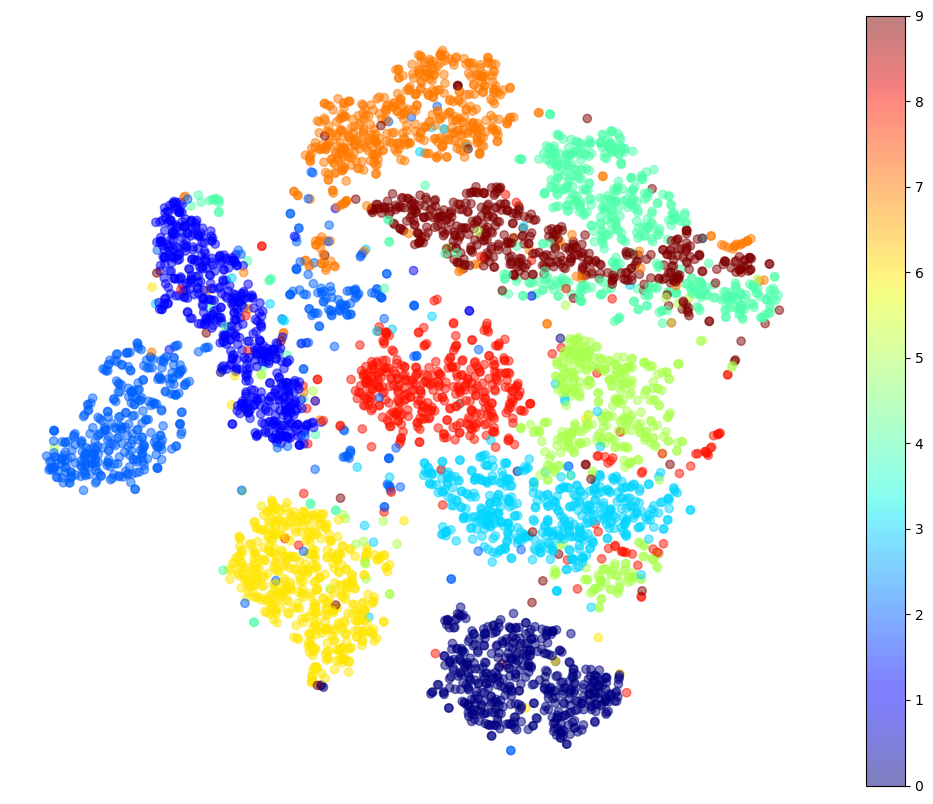

In [36]:
plt.figure(figsize = (13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
           c = y_sample.astype(np.int8), cmap = 'jet', alpha = 0.5)
plt.axis('off')
plt.colorbar()
plt.show()

Así tsne no tiene variables target el mismo agrupa los digitos muy bien, los 3 y los 5 se confunden, igual que los 4 y los 9. veamos los 4 y 9

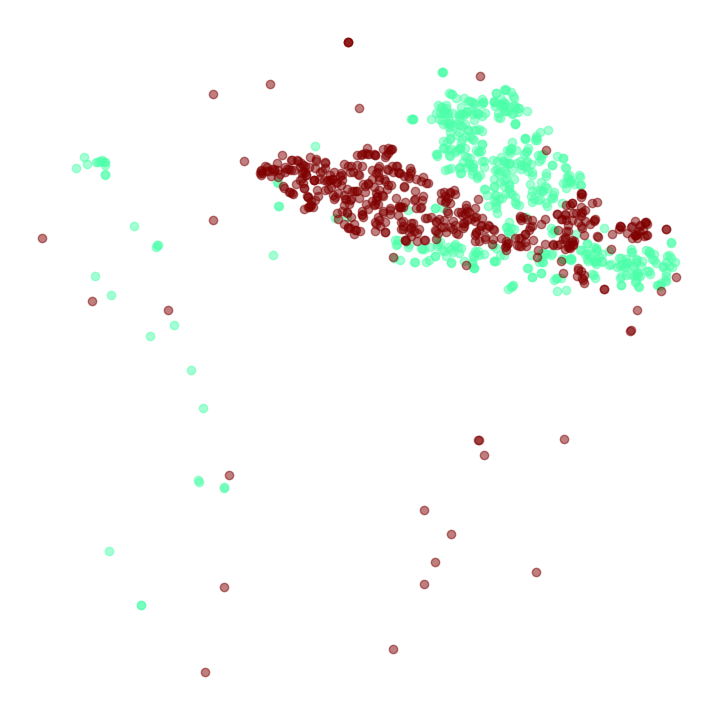

In [37]:
plt.figure(figsize = (9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
               c = [cmap(float(digit) / 9)], alpha = 0.5)
plt.axis('off')
plt.show()

Ahora ajustemos un tsne en solo estos dos digitos

In [38]:
idx = (y_sample == '4') | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components = 2, init = 'random', learning_rate = 'auto',
                  random_state = 42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

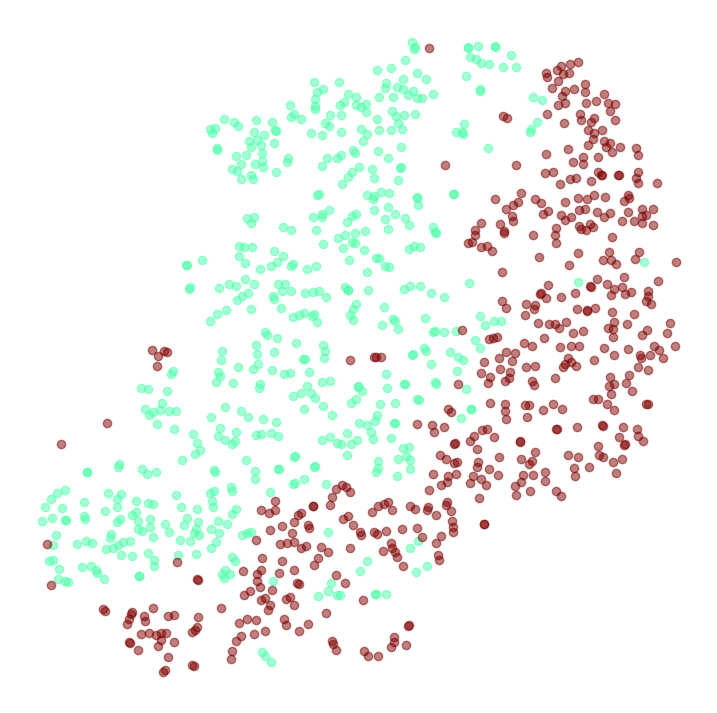

In [39]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

In [40]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

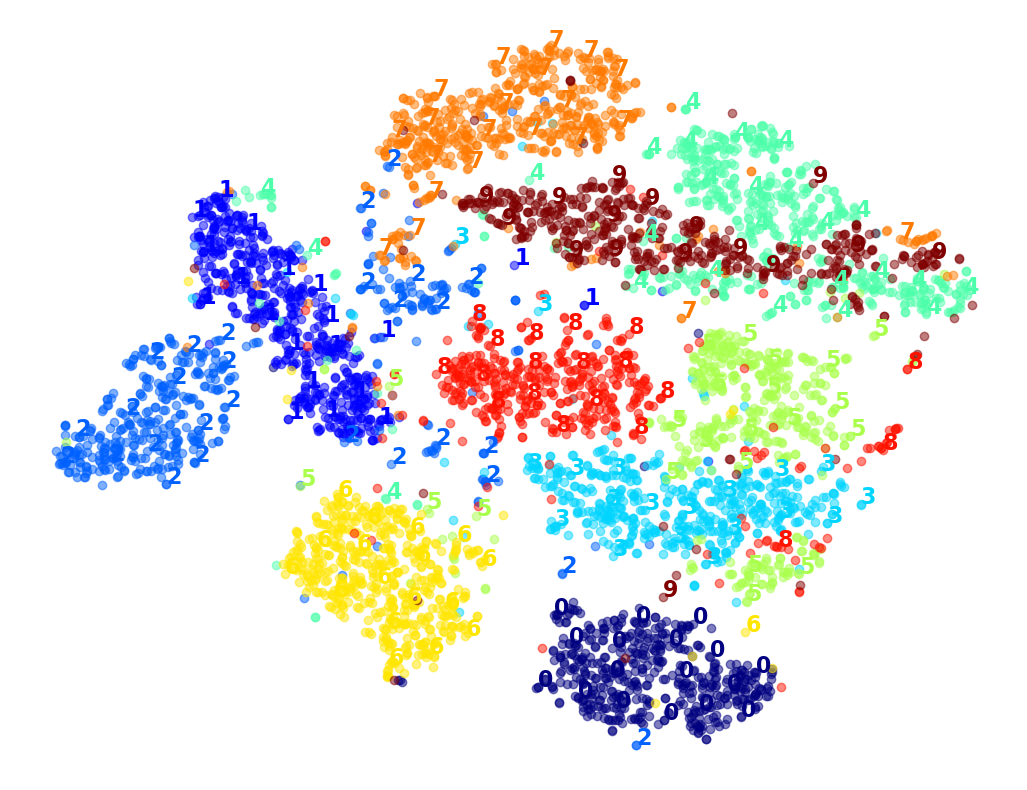

In [41]:
plot_digits(X_reduced, y_sample)

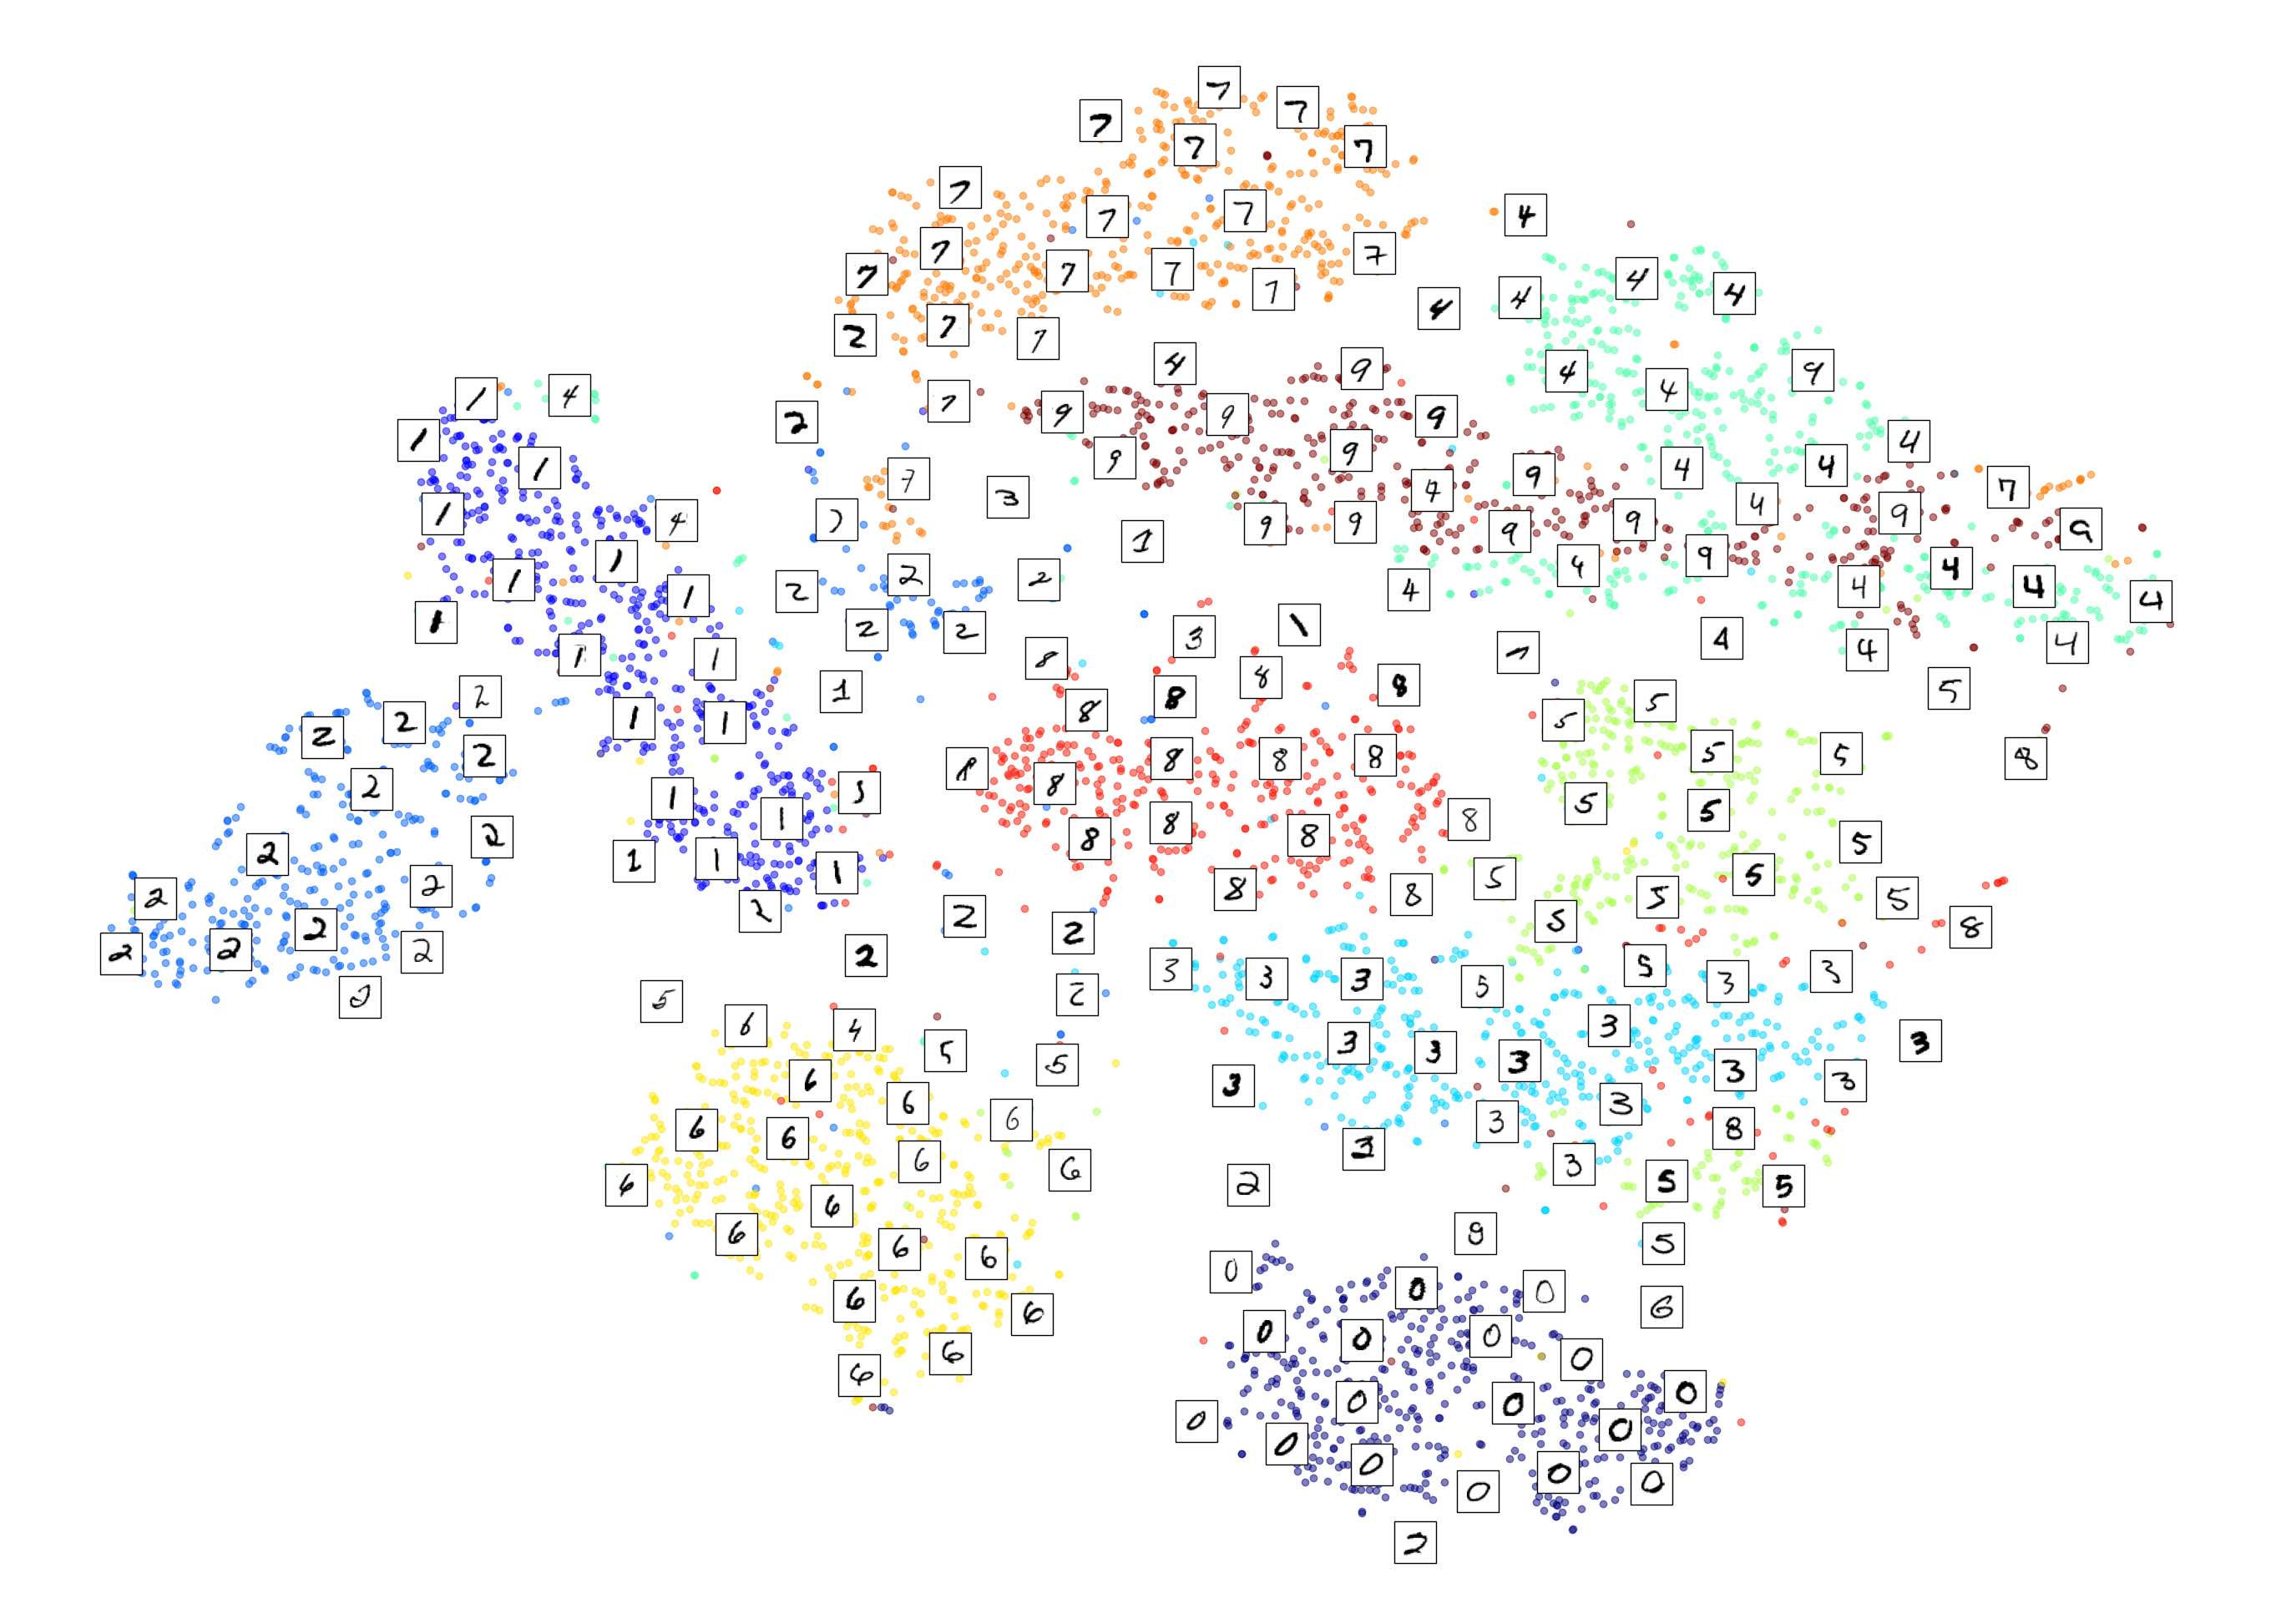

In [42]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

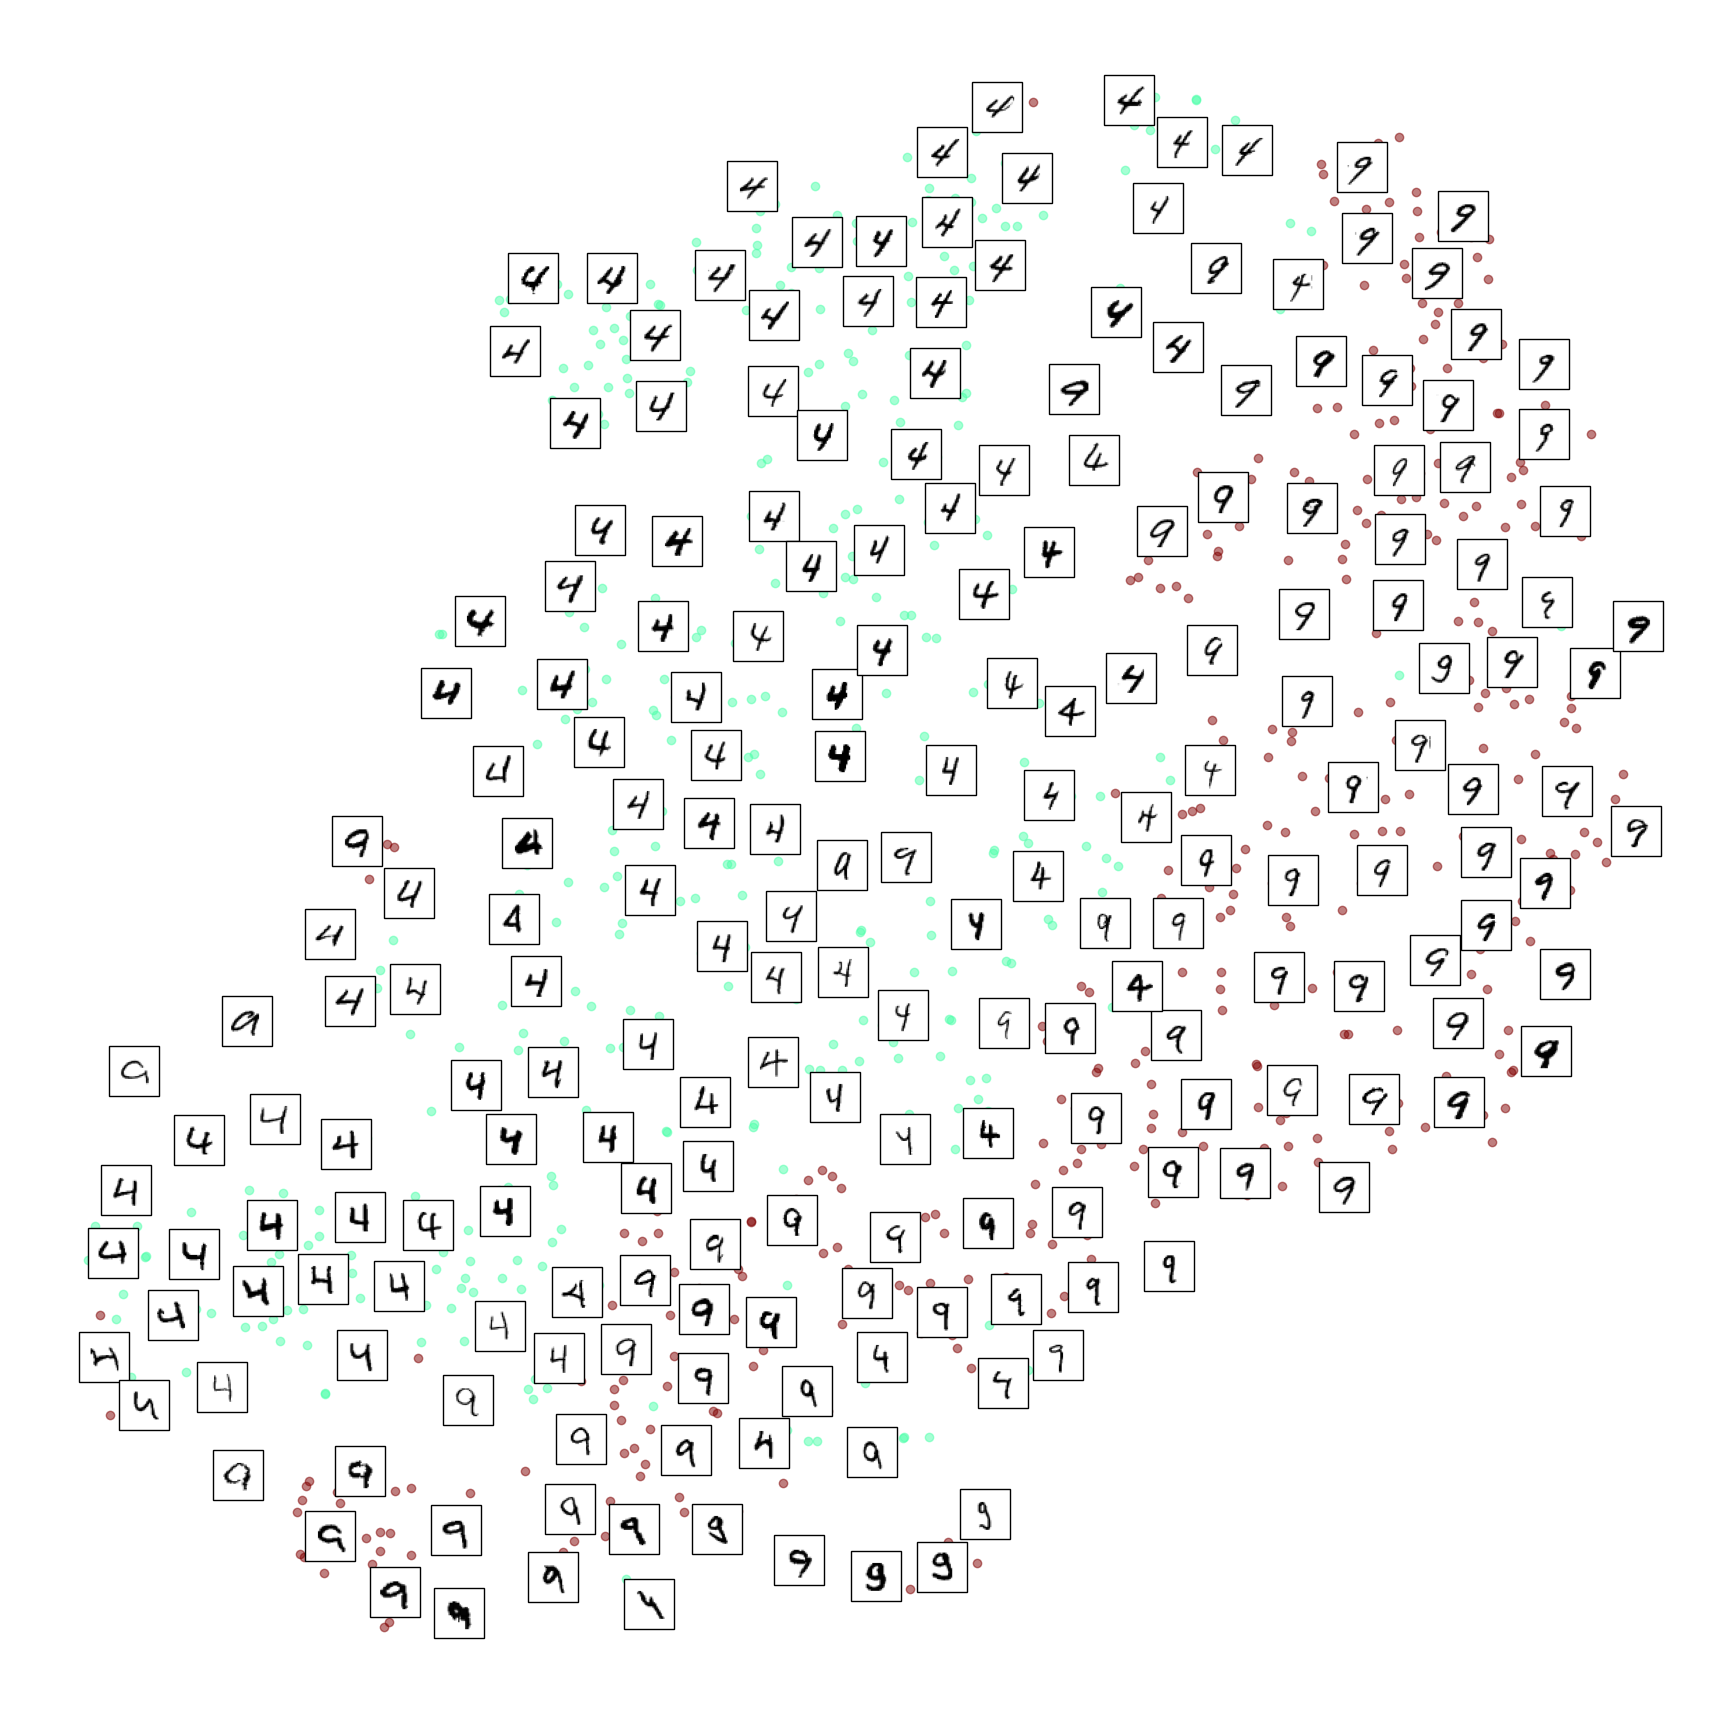

In [43]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

## PCA

Wall time: 135 ms


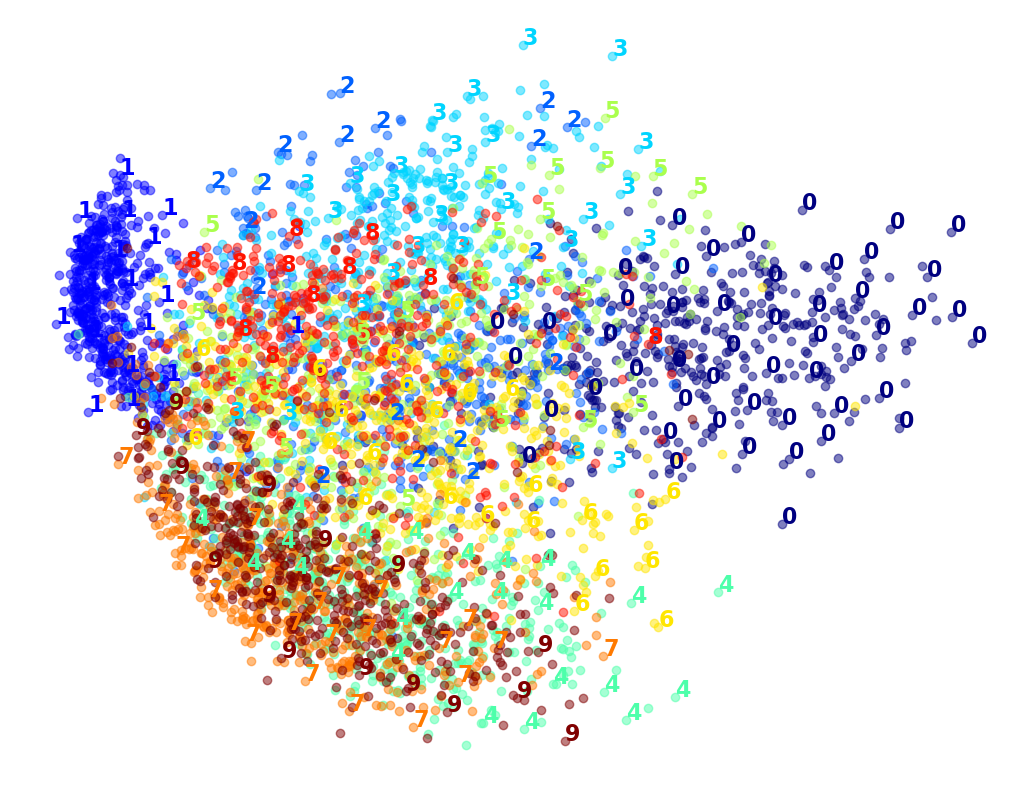

In [44]:
pca = PCA(n_components = 2, random_state = 42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

Es muy rápido, pero se ven muchos grupos superpuestos.

## LLE

Wall time: 2.3 s


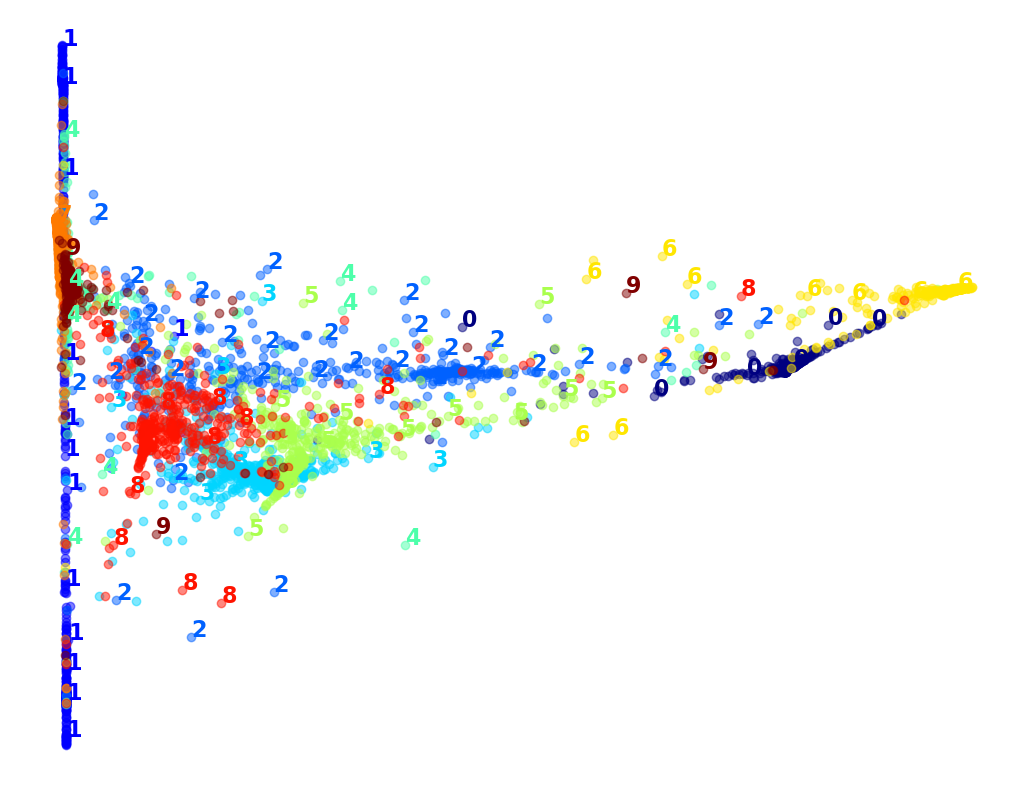

In [45]:
lle = LocallyLinearEmbedding(n_components = 2, random_state = 42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)
plt.show()

Fué rápido pero los grupos no son claros.

## MDS

Wall time: 13min 13s


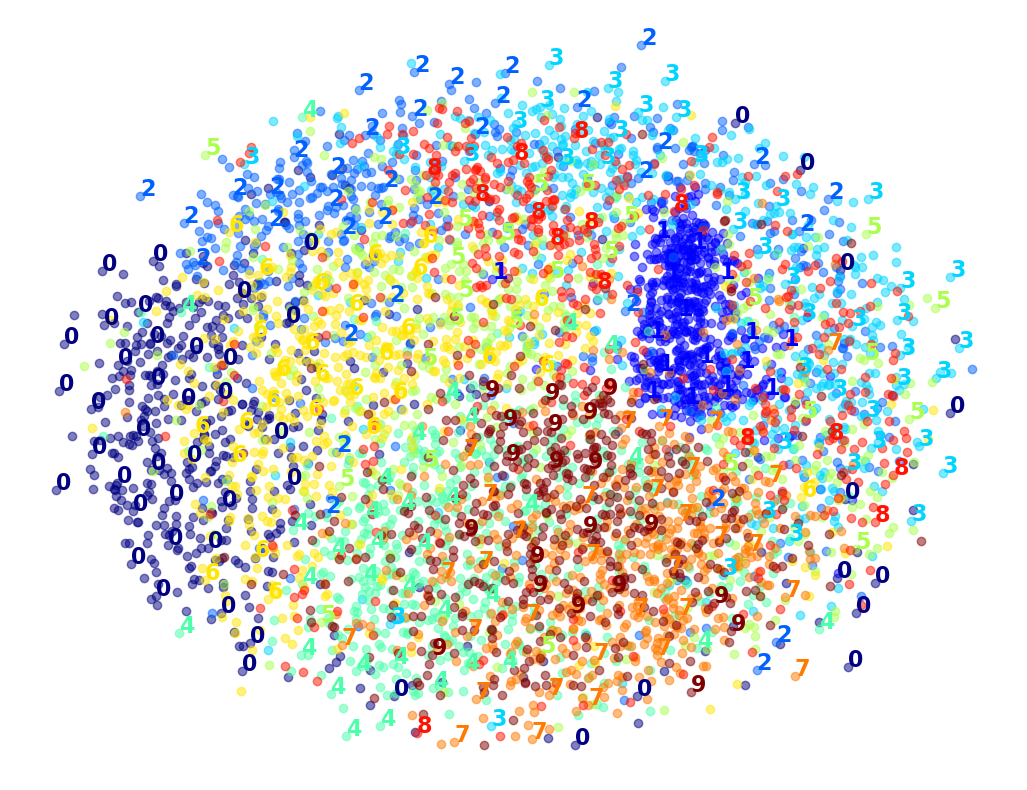

In [46]:
%time X_mds_reduced = MDS(n_components = 2, random_state = 42).fit_transform(X_sample)
plot_digits(X_mds_reduced, y_sample)
plt.show()

No se ve tan bien la separación, intentemos hacer PCA y después MDS

Wall time: 12min 43s


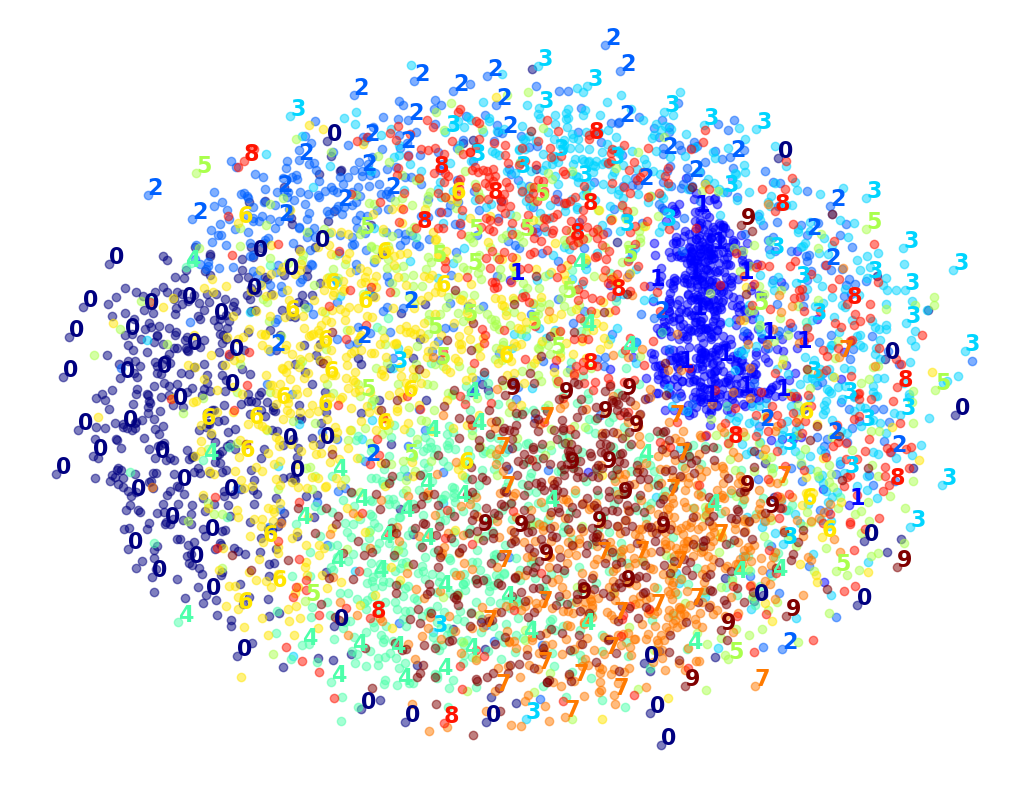

In [47]:
pca_mds = make_pipeline(PCA(n_components=0.95, random_state=42),
                        MDS(n_components=2, random_state=42))

%time X_pca_mds_reduced = pca_mds.fit_transform(X_sample)
plot_digits(X_pca_mds_reduced, y_sample)
plt.show()

No mejora mucho en ninguno de los dos ámbitos.

## LDA

Wall time: 590 ms


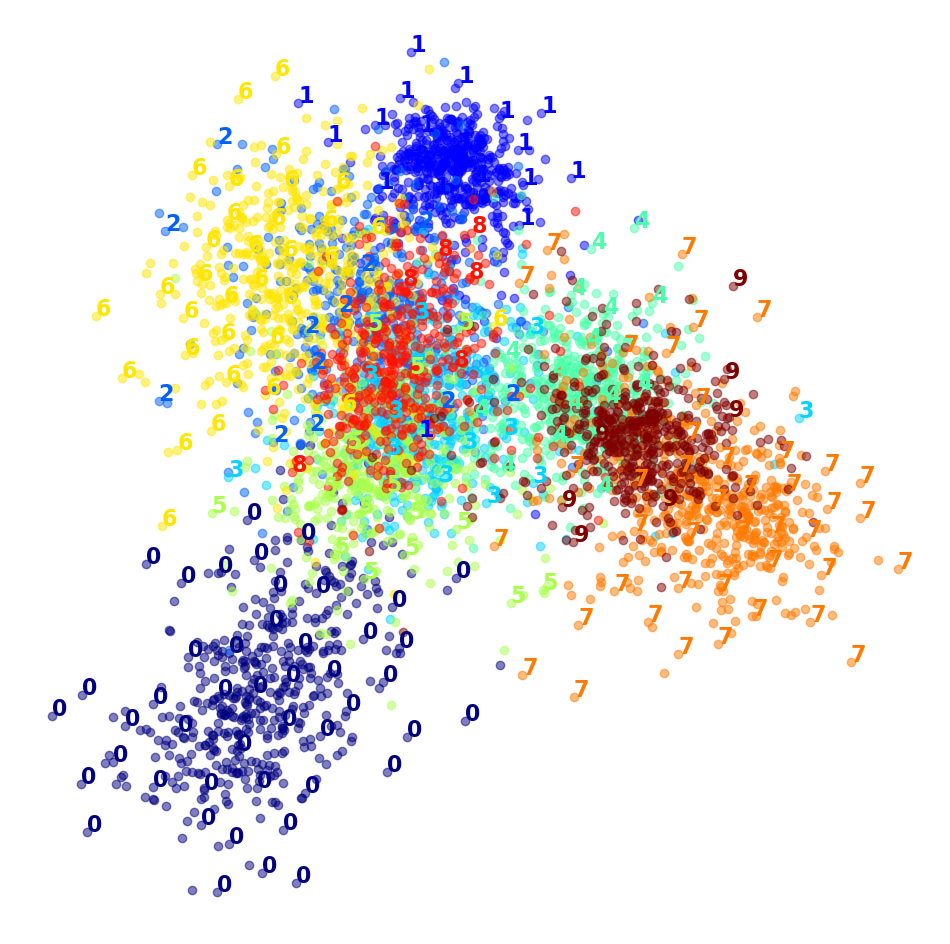

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = lda.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()

Parece mejor que los anteriores pero se superponen muchas observaciones t-SNE sigue siendo la mejor opción.